In [ ]:
!pip3 install librosa

In [ ]:
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

import tensorflow as tf
print(tf.__version__)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics

from app.website.extract_features import extract_mfcc, zero_crossing_rate

## Dataset

We check given directory to find all available *.wav* files.

In [2]:
# helper
def contains_number(s):
    return any(i.isdigit() for i in s)

In [3]:
#check source directory and find classes
source_dir = './vox_dev_wav/wav/'
# source_dir = './audio/'
speakers = [name for name in os.listdir(source_dir) if os.path.isdir(os.path.join(source_dir, name))]
print(speakers)
raw = []
for speaker in speakers:
    path = os.path.join(source_dir, speaker) + '/'
    print('checking dir:', path)
    folders = [f for f in os.listdir(path) if not f.startswith('.') ]
    for folder in folders:
        clip_path = os.path.join(path, folder) + '/'
        print(clip_path)
        clips = [f for f in os.listdir(clip_path) if f.endswith('.wav')]
        for clip in clips:
            raw.append({'speaker': speaker, 'path':clip_path+clip})

['id10009', 'id10007', 'id10006', 'id10001', 'id10008', 'id10012', 'id10015', 'id10014', 'id10013', 'id10004', 'id10003', 'id10002', 'id10005', 'id10016', 'id10011', 'id10018', 'id10020', 'id10019', 'id10010', 'id10017']
checking dir: ./vox_dev_wav/wav/id10009/
./vox_dev_wav/wav/id10009/HCGXIgKsozU/
./vox_dev_wav/wav/id10009/AtavJVP4bCk/
./vox_dev_wav/wav/id10009/x_HdUZuSusA/
./vox_dev_wav/wav/id10009/seo9TTTEoE4/
./vox_dev_wav/wav/id10009/7hpSiT9_gCE/
./vox_dev_wav/wav/id10009/JrwqvWr5_VE/
./vox_dev_wav/wav/id10009/FOFbkVlz-wQ/
./vox_dev_wav/wav/id10009/JntZkGsH2Cc/
./vox_dev_wav/wav/id10009/aFttHpeaXaQ/
./vox_dev_wav/wav/id10009/vy8sQ82o0fM/
./vox_dev_wav/wav/id10009/qdop2-gjKBQ/
./vox_dev_wav/wav/id10009/VM8gJWbQsEY/
./vox_dev_wav/wav/id10009/EJ3tyqGqYfw/
./vox_dev_wav/wav/id10009/sQIqfA-I_Ew/
checking dir: ./vox_dev_wav/wav/id10007/
./vox_dev_wav/wav/id10007/10Oe0XETA0s/
./vox_dev_wav/wav/id10007/ny4iV7xwhRM/
./vox_dev_wav/wav/id10007/HxfxcxUXPDA/
./vox_dev_wav/wav/id10007/G0lVD5d0

./vox_dev_wav/wav/id10011/TsWNxShkS9A/
./vox_dev_wav/wav/id10011/QmFNWMU2hKU/
./vox_dev_wav/wav/id10011/978HIG18Lek/
./vox_dev_wav/wav/id10011/0Wg6d-v2CrQ/
./vox_dev_wav/wav/id10011/YyB6Rk0bOSg/
./vox_dev_wav/wav/id10011/NY8rvshKUzU/
./vox_dev_wav/wav/id10011/ujWHD_MTa44/
./vox_dev_wav/wav/id10011/R8SJg-rcjKI/
./vox_dev_wav/wav/id10011/01En9rUo_Co/
checking dir: ./vox_dev_wav/wav/id10018/
./vox_dev_wav/wav/id10018/YOjilzTiE-Y/
./vox_dev_wav/wav/id10018/sci80gk6bUc/
./vox_dev_wav/wav/id10018/eckQg181kQY/
./vox_dev_wav/wav/id10018/A-Q7SmHQT70/
./vox_dev_wav/wav/id10018/TIFdSOTYIBg/
./vox_dev_wav/wav/id10018/9tu4uaM0YTc/
./vox_dev_wav/wav/id10018/EFFEzbt2k6o/
./vox_dev_wav/wav/id10018/RM55SnIw2uQ/
./vox_dev_wav/wav/id10018/iYaSdx4Qhv4/
./vox_dev_wav/wav/id10018/ZBioF6ulHg8/
./vox_dev_wav/wav/id10018/2fsToHH2Qz4/
./vox_dev_wav/wav/id10018/lCA6CCS7mxc/
./vox_dev_wav/wav/id10018/RBlk-zGCm0g/
./vox_dev_wav/wav/id10018/8WVqEfbZ4Ic/
./vox_dev_wav/wav/id10018/sqdHikUKOK0/
./vox_dev_wav/wav/id100

In [4]:
df = pd.DataFrame(raw)
# df = df[:100]
print(df.shape)
df.head()

(2787, 2)


,speaker,path
0,id10009,./vox_dev_wav/wav/id10009/HCGXIgKsozU/00001.wav
1,id10009,./vox_dev_wav/wav/id10009/AtavJVP4bCk/00009.wav
2,id10009,./vox_dev_wav/wav/id10009/AtavJVP4bCk/00008.wav
3,id10009,./vox_dev_wav/wav/id10009/AtavJVP4bCk/00006.wav
4,id10009,./vox_dev_wav/wav/id10009/AtavJVP4bCk/00007.wav


## Preprocessing and Feuture Extraction

* We split the dataset as 70% train and 30% test. The split is performed per speaker and not the entire dataset
* Then, we extract MFCC and Delta features

In [6]:
# create test dataframe, keep 0.7 of each speaker as train and 0.3 as test
train_split = 0.7
df_train_list = []
df_test_list = []
for id in df['speaker'].unique():
    speaker = df.loc[df['speaker'] == id]
    #suffle and split dataset
    speaker = speaker.sample(frac=1, replace=False, random_state=42)
    train_indices = int(round(train_split*len(speaker)))
    train = speaker[:train_indices]
    test = speaker[:len(speaker) - train_indices]
    df_train_list.append(train)
    df_test_list.append(test)

df_train = pd.concat(df_train_list)
df_test = pd.concat(df_test_list)
print(f'Train set size: {df_train.shape}, Test set size {df_test.shape}')

# sanity check, check if both train and test sets have same speakers
b = set(df_train['speaker'].unique()) == set(df_test['speaker'].unique())
b

Train set size: (1950, 2), Test set size (837, 2)


True

In [7]:
# number of mfccs per clip
n_mfcc = splits = 13

df_train[['mfcc','delta']] = df_train['path'].apply(lambda p: extract_mfcc(p, n_mfcc))
df_test[['mfcc','delta']] = df_test['path'].apply(lambda p: extract_mfcc(p, n_mfcc))

In [8]:
# extract Zero Crossing Rate
df_train[['zcr']] = df_train['path'].apply(lambda p: zero_crossing_rate(p, splits))
df_test[['zcr']] = df_test['path'].apply(lambda p: zero_crossing_rate(p, splits))

In [9]:
df_train.head()

,speaker,path,mfcc,delta,zcr
0,id10009,./vox_dev_wav/wav/id10009/HCGXIgKsozU/00001.wav,"[-234.83286, 133.73509, -31.300879, 38.71376, ...","[-0.22536033, -0.12889376, -0.028585024, 0.124...","[0.06953932387458399, 0.13154668067962866, 0.0..."
5,id10009,./vox_dev_wav/wav/id10009/AtavJVP4bCk/00005.wav,"[-423.196, 151.2904, -20.332306, -2.9083853, -...","[0.0002549889, -0.008353452, -0.00092818623, 0...","[0.09745702514561727, 0.16309134820286972, 0.0..."
34,id10009,./vox_dev_wav/wav/id10009/vy8sQ82o0fM/00004.wav,"[-271.4974, 132.00212, -48.866318, 48.387047, ...","[-0.20052902, 0.018294884, 0.1554059, 0.065510...","[0.2788184438040346, 0.25230547550432275, 0.25..."
13,id10009,./vox_dev_wav/wav/id10009/seo9TTTEoE4/00002.wav,"[-206.58463, 144.25214, -50.279385, 31.640982,...","[-0.05777987, 0.034374237, 0.038280718, 0.0138...","[0.14064959221633996, 0.1417942481041637, 0.10..."
45,id10009,./vox_dev_wav/wav/id10009/EJ3tyqGqYfw/00001.wav,"[-250.60458, 139.20047, -46.59575, 34.955204, ...","[0.0495788, -0.03894916, 0.045858603, -0.10095...","[0.19740464018875345, 0.14195831694848604, 0.1..."


In [10]:
df_test.head()

,speaker,path,mfcc,delta,zcr
0,id10009,./vox_dev_wav/wav/id10009/HCGXIgKsozU/00001.wav,"[-234.83286, 133.73509, -31.300879, 38.71376, ...","[-0.22536033, -0.12889376, -0.028585024, 0.124...","[0.06953932387458399, 0.13154668067962866, 0.0..."
5,id10009,./vox_dev_wav/wav/id10009/AtavJVP4bCk/00005.wav,"[-423.196, 151.2904, -20.332306, -2.9083853, -...","[0.0002549889, -0.008353452, -0.00092818623, 0...","[0.09745702514561727, 0.16309134820286972, 0.0..."
34,id10009,./vox_dev_wav/wav/id10009/vy8sQ82o0fM/00004.wav,"[-271.4974, 132.00212, -48.866318, 48.387047, ...","[-0.20052902, 0.018294884, 0.1554059, 0.065510...","[0.2788184438040346, 0.25230547550432275, 0.25..."
13,id10009,./vox_dev_wav/wav/id10009/seo9TTTEoE4/00002.wav,"[-206.58463, 144.25214, -50.279385, 31.640982,...","[-0.05777987, 0.034374237, 0.038280718, 0.0138...","[0.14064959221633996, 0.1417942481041637, 0.10..."
45,id10009,./vox_dev_wav/wav/id10009/EJ3tyqGqYfw/00001.wav,"[-250.60458, 139.20047, -46.59575, 34.955204, ...","[0.0495788, -0.03894916, 0.045858603, -0.10095...","[0.19740464018875345, 0.14195831694848604, 0.1..."


In [14]:
#split dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# keep mfcc and delta and zero crossing rate columns
X = df_train.iloc[:,2:5]
# keep speaker colum
y = df_train.iloc[:,0]

le = LabelEncoder()
le.fit(list(y))
num_labels=len(list(le.classes_))

y = le.fit_transform(y)
print(f'Number of speakers is {num_labels}')
# save label encoder to file
np.save('saved_models/classes.npy', le.classes_)
print(type(le))
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=21)

X_train = np.hstack((X_train['mfcc'].to_list(),X_train['delta'].to_list(), X_train['zcr'].to_list()))
X_val = np.hstack((X_val['mfcc'].to_list(), X_val['delta'].to_list(), X_val['zcr'].to_list()))
print(f'Train set size: {X_train.shape}, Validation set size {X_val.shape}')

Number of speakers is 20
<class 'sklearn.preprocessing._label.LabelEncoder'>
Train set size: (1365, 39), Validation set size (585, 39)


## Deep Learning Model

In [21]:
model=Sequential()
###first layer
model.add(Dense(100,input_shape=(X_train.shape[1],)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###second layer
model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###third layer
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.5))

###final layer
model.add(Dense(num_labels))
model.add(Activation('softmax'))
model.compile(loss='sparse_categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 100)               4000      
_________________________________________________________________
activation_8 (Activation)    (None, 100)               0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 200)               20200     
_________________________________________________________________
activation_9 (Activation)    (None, 200)               0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 100)              

In [22]:
## Train model
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime 

num_epochs = 200
num_batch_size = 8


earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=50)
checkpointer = ModelCheckpoint(filepath='saved_models/speakers_classification.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

model_h = model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, 
          validation_data=(X_val, y_val), callbacks=[checkpointer, earlystopping], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/200
171/171 [==============================] - 1s 6ms/step - loss: 26.9388 - accuracy: 0.0711 - val_loss: 2.9793 - val_accuracy: 0.1111

Epoch 00001: val_loss improved from inf to 2.97933, saving model to saved_models/speakers_classification.hdf5
Epoch 2/200
171/171 [==============================] - 1s 3ms/step - loss: 5.2176 - accuracy: 0.0747 - val_loss: 2.9557 - val_accuracy: 0.2188

Epoch 00002: val_loss improved from 2.97933 to 2.95566, saving model to saved_models/speakers_classification.hdf5
Epoch 3/200
171/171 [==============================] - 0s 3ms/step - loss: 3.4050 - accuracy: 0.1604 - val_loss: 2.9287 - val_accuracy: 0.2188

Epoch 00003: val_loss improved from 2.95566 to 2.92871, saving model to saved_models/speakers_classification.hdf5
Epoch 4/200
171/171 [==============================] - 0s 3ms/step - loss: 3.1864 - accuracy: 0.1634 - val_loss: 2.9002 - val_accuracy: 0.2188

Epoch 00004: val_loss improved from 2.92871 to 2.90020, saving model to saved_models/

Epoch 35/200
171/171 [==============================] - 1s 5ms/step - loss: 2.3003 - accuracy: 0.2923 - val_loss: 2.2424 - val_accuracy: 0.2940

Epoch 00035: val_loss did not improve from 2.23178
Epoch 36/200
171/171 [==============================] - 1s 3ms/step - loss: 2.3095 - accuracy: 0.2982 - val_loss: 2.2441 - val_accuracy: 0.2923

Epoch 00036: val_loss did not improve from 2.23178
Epoch 37/200
171/171 [==============================] - 0s 2ms/step - loss: 2.2947 - accuracy: 0.2989 - val_loss: 2.2090 - val_accuracy: 0.3094

Epoch 00037: val_loss improved from 2.23178 to 2.20904, saving model to saved_models/speakers_classification.hdf5
Epoch 38/200
171/171 [==============================] - 0s 3ms/step - loss: 2.2720 - accuracy: 0.2916 - val_loss: 2.1815 - val_accuracy: 0.2906

Epoch 00038: val_loss improved from 2.20904 to 2.18146, saving model to saved_models/speakers_classification.hdf5
Epoch 39/200
171/171 [==============================] - 0s 3ms/step - loss: 2.2530 - accur


Epoch 00070: val_loss did not improve from 1.52348
Epoch 71/200
171/171 [==============================] - 1s 5ms/step - loss: 1.7842 - accuracy: 0.4476 - val_loss: 1.5568 - val_accuracy: 0.5316

Epoch 00071: val_loss did not improve from 1.52348
Epoch 72/200
171/171 [==============================] - 1s 5ms/step - loss: 1.7924 - accuracy: 0.4410 - val_loss: 1.5703 - val_accuracy: 0.5350

Epoch 00072: val_loss did not improve from 1.52348
Epoch 73/200
171/171 [==============================] - 1s 5ms/step - loss: 1.8018 - accuracy: 0.4198 - val_loss: 1.5824 - val_accuracy: 0.5145

Epoch 00073: val_loss did not improve from 1.52348
Epoch 74/200
171/171 [==============================] - 1s 5ms/step - loss: 1.7826 - accuracy: 0.4425 - val_loss: 1.4941 - val_accuracy: 0.5316

Epoch 00074: val_loss improved from 1.52348 to 1.49412, saving model to saved_models/speakers_classification.hdf5
Epoch 75/200
171/171 [==============================] - 1s 5ms/step - loss: 1.7794 - accuracy: 0.4344

171/171 [==============================] - 1s 8ms/step - loss: 1.6248 - accuracy: 0.4799 - val_loss: 1.4290 - val_accuracy: 0.5778

Epoch 00109: val_loss did not improve from 1.34720
Epoch 110/200
171/171 [==============================] - 1s 6ms/step - loss: 1.6031 - accuracy: 0.4835 - val_loss: 1.3617 - val_accuracy: 0.5983

Epoch 00110: val_loss did not improve from 1.34720
Epoch 111/200
171/171 [==============================] - 1s 7ms/step - loss: 1.6608 - accuracy: 0.4791 - val_loss: 1.3747 - val_accuracy: 0.5880

Epoch 00111: val_loss did not improve from 1.34720
Epoch 112/200
171/171 [==============================] - 1s 4ms/step - loss: 1.6557 - accuracy: 0.4652 - val_loss: 1.4903 - val_accuracy: 0.5573

Epoch 00112: val_loss did not improve from 1.34720
Epoch 113/200
171/171 [==============================] - 1s 7ms/step - loss: 1.6722 - accuracy: 0.4571 - val_loss: 1.3981 - val_accuracy: 0.6103

Epoch 00113: val_loss did not improve from 1.34720
Epoch 114/200
171/171 [======

171/171 [==============================] - 1s 4ms/step - loss: 1.6317 - accuracy: 0.4886 - val_loss: 1.3974 - val_accuracy: 0.5897

Epoch 00149: val_loss did not improve from 1.30152
Epoch 150/200
171/171 [==============================] - 1s 3ms/step - loss: 1.5936 - accuracy: 0.4974 - val_loss: 1.3864 - val_accuracy: 0.5863

Epoch 00150: val_loss did not improve from 1.30152
Epoch 151/200
171/171 [==============================] - 0s 3ms/step - loss: 1.5691 - accuracy: 0.4982 - val_loss: 1.3616 - val_accuracy: 0.5949

Epoch 00151: val_loss did not improve from 1.30152
Epoch 152/200
171/171 [==============================] - 0s 3ms/step - loss: 1.5863 - accuracy: 0.4872 - val_loss: 1.3837 - val_accuracy: 0.5932

Epoch 00152: val_loss did not improve from 1.30152
Epoch 153/200
171/171 [==============================] - 0s 3ms/step - loss: 1.5683 - accuracy: 0.5018 - val_loss: 1.3362 - val_accuracy: 0.5949

Epoch 00153: val_loss did not improve from 1.30152
Epoch 154/200
171/171 [======


Epoch 00189: val_loss did not improve from 1.27315
Epoch 190/200
171/171 [==============================] - 1s 3ms/step - loss: 1.5132 - accuracy: 0.5231 - val_loss: 1.3376 - val_accuracy: 0.6308

Epoch 00190: val_loss did not improve from 1.27315
Epoch 191/200
171/171 [==============================] - 0s 2ms/step - loss: 1.5678 - accuracy: 0.5055 - val_loss: 1.3218 - val_accuracy: 0.6017

Epoch 00191: val_loss did not improve from 1.27315
Epoch 192/200
171/171 [==============================] - 0s 2ms/step - loss: 1.5433 - accuracy: 0.5231 - val_loss: 1.3089 - val_accuracy: 0.6188

Epoch 00192: val_loss did not improve from 1.27315
Epoch 193/200
171/171 [==============================] - 0s 2ms/step - loss: 1.4995 - accuracy: 0.5275 - val_loss: 1.2779 - val_accuracy: 0.6171

Epoch 00193: val_loss did not improve from 1.27315
Epoch 194/200
171/171 [==============================] - 0s 3ms/step - loss: 1.5036 - accuracy: 0.5216 - val_loss: 1.3095 - val_accuracy: 0.6222

Epoch 00194: v

### Check training history

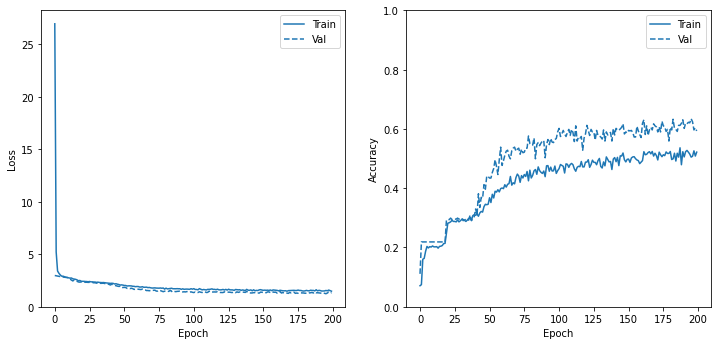

In [23]:
# import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,12)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
def plot_metrics(history):
  metrics = ['loss', 'accuracy']#, 'f1_m', 'recall_m']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

plot_metrics(model_h)

### Predict and Classification Report

In [24]:
from sklearn.metrics import classification_report

X_test = np.hstack((df_test['mfcc'].to_list(),
                    df_test['delta'].to_list(),
                    df_test['zcr'].to_list()))
print(X_test.shape)
y_true = df_test['speaker']

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_pred = le.classes_[y_pred]
print(y_pred)
print(classification_report(y_true, y_pred, target_names=le.classes_))

(837, 39)
['id10016' 'id10009' 'id10004' 'id10004' 'id10016' 'id10004' 'id10004'
 'id10016' 'id10004' 'id10011' 'id10001' 'id10009' 'id10004' 'id10004'
 'id10009' 'id10011' 'id10009' 'id10009' 'id10007' 'id10007' 'id10004'
 'id10007' 'id10007' 'id10016' 'id10004' 'id10004' 'id10007' 'id10009'
 'id10007' 'id10007' 'id10004' 'id10007' 'id10011' 'id10011' 'id10004'
 'id10007' 'id10007' 'id10007' 'id10001' 'id10007' 'id10014' 'id10007'
 'id10006' 'id10014' 'id10006' 'id10015' 'id10004' 'id10004' 'id10006'
 'id10006' 'id10011' 'id10014' 'id10006' 'id10006' 'id10014' 'id10006'
 'id10014' 'id10006' 'id10016' 'id10006' 'id10006' 'id10006' 'id10006'
 'id10014' 'id10004' 'id10006' 'id10009' 'id10006' 'id10004' 'id10006'
 'id10006' 'id10006' 'id10006' 'id10014' 'id10006' 'id10006' 'id10006'
 'id10014' 'id10004' 'id10014' 'id10008' 'id10004' 'id10001' 'id10001'
 'id10011' 'id10004' 'id10001' 'id10011' 'id10011' 'id10016' 'id10001'
 'id10016' 'id10006' 'id10016' 'id10016' 'id10004' 'id10001' 'id100

/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# clip = '/Users/vpapadop/Documents/GitHub/speaker-similarity/vox_dev_wav/wav/id10001/1zcIwhmdeo4/00001.wav'
# tmp = pd.DataFrame()
# tmp[['mfcc', 'delta']] = extract_mfcc(clip,20)
# X_tmp = np.hstack((tmp['mfcc'].to_list(),tmp['delta'].to_list()))
# X_tmp = np.expand_dims(X_tmp, axis=0)
# print(X_tmp.shape)

# y_pred = model.predict(X_tmp)
# print(y_pred)

## Gausian Mixture Model